##Data Preprocessing

###Whole data

In [ ]:
import pandas as pd

# Load the sample input features file
df = pd.read_excel("Predictive model input features_combined.xlsx")

In [ ]:
# Ensure consistent column naming for the join key
df.rename(columns={"Match ID 18Char": "match_id"}, inplace=True)

# Convert Match Activation Date to datetime
df["Match Activation Date"] = pd.to_datetime(df["Match Activation Date"])

In [ ]:
# (Optional) Inspect result
print(df.columns)

Index(['Row', 'match_id', 'Completion Date', 'Comment_Dict',
       'Avg_Cadence_Days', 'Call Frequency', 'Stage', 'Little ID', 'Big ID',
       'Big County', 'Big Age', 'Big Gender', 'Big Race Category',
       'Big Occupation Category', 'Little Gender', 'Little Race Category',
       'Little Closure Age', 'Match Activation Date', 'Match Length',
       'Closure Reason', 'Unresponsiveness_Mentioned',
       'External_Stressors_Mentioned', 'Conflict_Language_Mentioned',
       'Future_Oriented_Language', 'Shared_Interest',
       'Communication_Support_Positive', 'Conflict_concerns_policy_flag',
       'Relationship_quality_positive', 'Shared_interest_count',
       'Engagement_consistency_positive', 'Mental_health_growth_positive',
       'Sense_of_Growth', 'Child_Safety_Concern'],
      dtype='object')


In [ ]:
import numpy as np

# Set your global parameter
X_PERCENTILE = 100  # Top 30%

# Make a safe copy of the original data
original_df = df.copy()

# Function to get top X% of rows for each match_id, sorted by completion_date
def get_top_percentile_per_match(df, group_col, percentile):
    def top_x_percent(group):
        group = group.sort_values(by="Completion Date")  # sort before slicing
        group_size = len(group)
        cutoff = int(np.ceil(group_size * percentile / 100))
        return group.head(cutoff)

    return df.groupby(group_col, group_keys=False).apply(top_x_percent)

# Apply the function
merged_df = get_top_percentile_per_match(original_df, group_col='match_id', percentile=X_PERCENTILE)


In [ ]:
# Sort by match_id and completion_date
df = df.sort_values(by=['match_id', 'Completion Date'])

# Calculate days since last call
def calculate_days(group):
    group = group.sort_values(by="Completion Date")
    group["days_since_last_call"] = group["Completion Date"].diff().dt.days
    # For the first call, use Match Activation Date
    group.iloc[0, group.columns.get_loc("days_since_last_call")] = (
        group.iloc[0]["Completion Date"] - group.iloc[0]["Match Activation Date"]
    ).days
    return group

result_df = df.groupby("match_id").apply(calculate_days).reset_index(drop=True)

In [ ]:
# Create a separate DataFrame with only match_id and all features
#Call Frequency (Numericak) - Average
grouped_df = df.groupby("match_id")["Call Frequency"].count().reset_index()
grouped_df.rename(columns={"Call Frequency": "avg_call_frequency_days"}, inplace=True)


In [ ]:
#Cadence Days (Numerical)
# Compute stats from days_since_last_call grouped by match_id
call_stats = result_df.groupby("match_id")["days_since_last_call"].agg(
    std_days="std",
    var_days="var",
    min_days="min",
    max_days="max",
    mean_days="mean"
).reset_index()

# Merge this with the average call frequency dataframe
final_df = pd.merge(grouped_df, call_stats, on="match_id", how="left")


In [ ]:
#Shared Interest Count (Numerical)
# Basic stats: std, var, min, max, mean
interest_stats = result_df.groupby("match_id")["Shared_interest_count"].agg(
    std_shared="std",
    var_shared="var",
    min_shared="min",
    max_shared="max",
    mean_shared="mean"
).reset_index()

# Merge stats + mode for Shared_interest_count
final_df = pd.merge(final_df, interest_stats, on="match_id", how="left")



In [ ]:
#Child safet Concern and Conflict concerns policy flag
# Ensure binary columns are in numeric 0/1 format
result_df["Child_Safety_Concern"] = pd.to_numeric(result_df["Child_Safety_Concern"], errors="coerce").fillna(0).astype(int)
result_df["Conflict_concerns_policy_flag"] = pd.to_numeric(result_df["Conflict_concerns_policy_flag"], errors="coerce").fillna(0).astype(int)

# Group by match_id and set flag to 1 if it appears at least once
binary_flags = result_df.groupby("match_id")[["Child_Safety_Concern", "Conflict_concerns_policy_flag"]].max().reset_index()

# Merge into final_df
final_df = final_df.merge(binary_flags, on="match_id", how="left")

In [ ]:
# List of columns to calculate mean
mean_columns = [
    "Engagement_consistency_positive",
    "Mental_health_growth_positive",
    "Sense_of_Growth",
    "Relationship_quality_positive",
    "Unresponsiveness_Mentioned",
    "External_Stressors_Mentioned",
    "Conflict_Language_Mentioned",
    "Future_Oriented_Language",
    "Shared_Interest",
    "Communication_Support_Positive",
    "Conflict_concerns_policy_flag"
]

# Ensure all columns are numeric
for col in mean_columns:
    result_df[col] = pd.to_numeric(result_df[col], errors='coerce')

# Group by match_id and calculate the mean
mean_df = result_df.groupby("match_id")[mean_columns].mean().reset_index()

# Rename the mean of Conflict_concerns_policy_flag
mean_df.rename(columns={"Conflict_concerns_policy_flag": "Conflict_concerns_policy_flag_prop"}, inplace=True)

# Merge into final_df
final_df = final_df.merge(mean_df, on="match_id", how="left")


In [ ]:
# Columns to keep from result_df
cols_to_merge = [
    "match_id",
    "Completion Date", "Stage", "Match Activation Date",
    "Little ID", "Big ID", "Big County",
    "Big Age", "Big Gender", "Big Race Category", "Big Occupation Category",
    "Little Gender", "Little Race Category", "Little Closure Age","Match Length","Closure Reason"
]

# Take first occurrence of each match_id for merging fields
demographics_df = result_df[cols_to_merge].drop_duplicates(subset="match_id")

# Merge into final_df
final_df = final_df.merge(demographics_df, on="match_id", how="left")


In [ ]:
final_df.to_excel('For_Prediction_Model.xlsx')

In [ ]:
from google.colab import files
files.download("For_Prediction_Model.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###30% test data

In [ ]:
import pandas as pd

# Load the sample input features file
df = pd.read_excel("Predictive model input features_combined.xlsx")

In [ ]:
# Ensure consistent column naming for the join key
df.rename(columns={"Match ID 18Char": "match_id"}, inplace=True)

# Convert Match Activation Date to datetime
df["Match Activation Date"] = pd.to_datetime(df["Match Activation Date"])

In [ ]:
import numpy as np

# Set your global parameter
X_PERCENTILE = 30  # Top 30%

# Make a safe copy of the original data
original_df = df.copy()

# Function to get top X% of rows for each match_id, sorted by completion_date
def get_top_percentile_per_match(df, group_col, percentile):
    def top_x_percent(group):
        group = group.sort_values(by="Completion Date")  # sort before slicing
        group_size = len(group)
        cutoff = int(np.ceil(group_size * percentile / 100))
        return group.head(cutoff)

    return df.groupby(group_col, group_keys=False).apply(top_x_percent)

# Apply the function
merged_df = get_top_percentile_per_match(original_df, group_col='match_id', percentile=X_PERCENTILE)

In [ ]:
# Sort by match_id and completion_date
df = df.sort_values(by=['match_id', 'Completion Date'])

# Calculate days since last call
def calculate_days(group):
    group = group.sort_values(by="Completion Date")
    group["days_since_last_call"] = group["Completion Date"].diff().dt.days
    # For the first call, use Match Activation Date
    group.iloc[0, group.columns.get_loc("days_since_last_call")] = (
        group.iloc[0]["Completion Date"] - group.iloc[0]["Match Activation Date"]
    ).days
    return group

result_df = merged_df.groupby("match_id").apply(calculate_days).reset_index(drop=True)

In [ ]:
# Create a separate DataFrame with only match_id and all features
#Call Frequency (Numericak) - Average
grouped_df = merged_df.groupby("match_id")["Call Frequency"].count().reset_index()
grouped_df.rename(columns={"Call Frequency": "avg_call_frequency_days"}, inplace=True)

In [ ]:
#Cadence Days (Numerical)
# Compute stats from days_since_last_call grouped by match_id
call_stats = result_df.groupby("match_id")["days_since_last_call"].agg(
    std_days="std",
    var_days="var",
    min_days="min",
    max_days="max",
    mean_days="mean"
).reset_index()

# Merge this with the average call frequency dataframe
final_df = pd.merge(grouped_df, call_stats, on="match_id", how="left")

In [ ]:
#Shared Interest Count (Numerical)
# Basic stats: std, var, min, max, mean
interest_stats = result_df.groupby("match_id")["Shared_interest_count"].agg(
    std_shared="std",
    var_shared="var",
    min_shared="min",
    max_shared="max",
    mean_shared="mean"
).reset_index()

# Merge stats + mode for Shared_interest_count
final_df = pd.merge(final_df, interest_stats, on="match_id", how="left")

In [ ]:
#Child safet Concern and Conflict concerns policy flag
# Ensure binary columns are in numeric 0/1 format
result_df["Child_Safety_Concern"] = pd.to_numeric(result_df["Child_Safety_Concern"], errors="coerce").fillna(0).astype(int)
result_df["Conflict_concerns_policy_flag"] = pd.to_numeric(result_df["Conflict_concerns_policy_flag"], errors="coerce").fillna(0).astype(int)

# Group by match_id and set flag to 1 if it appears at least once
binary_flags = result_df.groupby("match_id")[["Child_Safety_Concern", "Conflict_concerns_policy_flag"]].max().reset_index()

# Merge into final_df
final_df = final_df.merge(binary_flags, on="match_id", how="left")

In [ ]:
# List of columns to calculate mean
mean_columns = [
    "Engagement_consistency_positive",
    "Mental_health_growth_positive",
    "Sense_of_Growth",
    "Relationship_quality_positive",
    "Unresponsiveness_Mentioned",
    "External_Stressors_Mentioned",
    "Conflict_Language_Mentioned",
    "Future_Oriented_Language",
    "Shared_Interest",
    "Communication_Support_Positive",
    "Conflict_concerns_policy_flag"
]

# Ensure all columns are numeric
for col in mean_columns:
    result_df[col] = pd.to_numeric(result_df[col], errors='coerce')

# Group by match_id and calculate the mean
mean_df = result_df.groupby("match_id")[mean_columns].mean().reset_index()

# Rename the mean of Conflict_concerns_policy_flag
mean_df.rename(columns={"Conflict_concerns_policy_flag": "Conflict_concerns_policy_flag_prop"}, inplace=True)

# Merge into final_df
final_df = final_df.merge(mean_df, on="match_id", how="left")

In [ ]:
# Columns to keep from result_df
cols_to_merge = [
    "match_id",
    "Completion Date", "Stage", "Match Activation Date",
    "Little ID", "Big ID", "Big County",
    "Big Age", "Big Gender", "Big Race Category", "Big Occupation Category",
    "Little Gender", "Little Race Category", "Little Closure Age","Match Length","Closure Reason"
]

# Take first occurrence of each match_id for merging fields
demographics_df = result_df[cols_to_merge].drop_duplicates(subset="match_id")

# Merge into final_df
final_df = final_df.merge(demographics_df, on="match_id", how="left")

In [ ]:
final_df.to_excel('prediction_training_30%.xlsx')

In [ ]:
from google.colab import files
files.download("prediction_training_30%.xlsx")

##Prediction Model

In [ ]:
# import packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load the prediction model
df_prediction = pd.read_excel("prediction_training_100.xlsx")

In [ ]:
# use pd.get_dummies() to do One-Hot Encoding
df_prediction = pd.get_dummies(df_prediction, columns=['Big Gender', 'Big Race Category',
                                                     'Big Occupation Category',
                                                     'Little Gender', 'Little Race Category'])


In [ ]:
# data preparation
X = df_prediction.drop(columns=['Match Length', 'match_id'])
y = df_prediction['Match Length']

# Split the dataset using train_test_split: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set outer cross-validation (10-fold)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Set inner cross-validation (5-fold)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
## Define hyperparameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3]
}
# Define hyperparameter grid for LightGBM
param_grid_lgbm = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3]
}

# Initialize models
rf = RandomForestRegressor()
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')
lgbm_model = lgb.LGBMRegressor(objective='regression')

# Perform inner cross-validation with GridSearchCV and outer cross-validation

# Random Forest
rf_gscv = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=inner_cv, scoring='neg_root_mean_squared_error')
rf_nested_cv = cross_val_score(rf_gscv, X_train, y_train, cv=outer_cv, scoring='neg_root_mean_squared_error')

# XGBoost
xgb_gscv = GridSearchCV(estimator=xgboost_model, param_grid=param_grid_xgb, cv=inner_cv, scoring='neg_root_mean_squared_error')
xgb_nested_cv = cross_val_score(xgb_gscv, X_train, y_train, cv=outer_cv, scoring='neg_root_mean_squared_error')

# LightGBM
lgbm_gscv = GridSearchCV(estimator=lgbm_model, param_grid=param_grid_lgbm, cv=inner_cv, scoring='neg_root_mean_squared_error')
lgbm_nested_cv = cross_val_score(lgbm_gscv, X_train, y_train, cv=outer_cv, scoring='neg_root_mean_squared_error')

# Display the average RMSE for each model
print(f"Random Forest - Average RMSE: {-np.mean(rf_nested_cv)}")
print(f"XGBoost - Average RMSE: {-np.mean(xgb_nested_cv)}")
print(f"LightGBM - Average RMSE: {-np.mean(lgbm_nested_cv)}")

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
# Data preparation
X = df_prediction.drop(columns=['Match Length', 'match_id'])
y = df_prediction['Match Length']

# Split the dataset using train_test_split: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter grid for LightGBM
param_grid_lgbm = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3]
}

# Initialize LightGBM model
lgbm_model = lgb.LGBMRegressor(objective='regression')

# Perform cross-validation using GridSearchCV
lgbm_gscv = GridSearchCV(
    estimator=lgbm_model,
    param_grid=param_grid_lgbm,
    cv=5,  # 5-fold cross-validation
    scoring='neg_root_mean_squared_error'
)

# Train the model
lgbm_gscv.fit(X_train, y_train)

# Best model from GridSearchCV
best_model_lgbm = lgbm_gscv.best_estimator_

# Make predictions on the test set
y_pred_lgbm = best_model_lgbm.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))

print(f"LightGBM - Test RMSE: {rmse}")

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

##Best Parameter

In [ ]:
# LightGBM
lgbm_gscv.fit(X_train, y_train)
print("LightGBM Best Parameters:", lgbm_gscv.best_params_)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

##feature importance

In [ ]:
#train LightGBM
lgbm_gscv.fit(X_train, y_train)
lgbm_best_model = lgbm_gscv.best_estimator_

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
#get Feature Importance: LightGBM
lgbm_feature_importance = best_model_lgbm.feature_importances_
lgbm_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': lgbm_feature_importance})
lgbm_importance_df = lgbm_importance_df.sort_values(by='Importance', ascending=False)
print("LightGBM Feature Importance")
print(lgbm_importance_df)

LightGBM Feature Importance
                                   Feature  Importance
3                                 max_days         254
4                                mean_days         239
0                                 std_days         204
5                               std_shared         104
13           Mental_health_growth_positive          90
..                                     ...         ...
62     Little Gender_Genderqueer/Nonbinary           0
69            Little Race Category_Missing           0
68         Little Race Category_Indigenous           0
72   Little Race Category_Pacific Islander           0
73  Little Race Category_Prefer not to say           0

[75 rows x 2 columns]


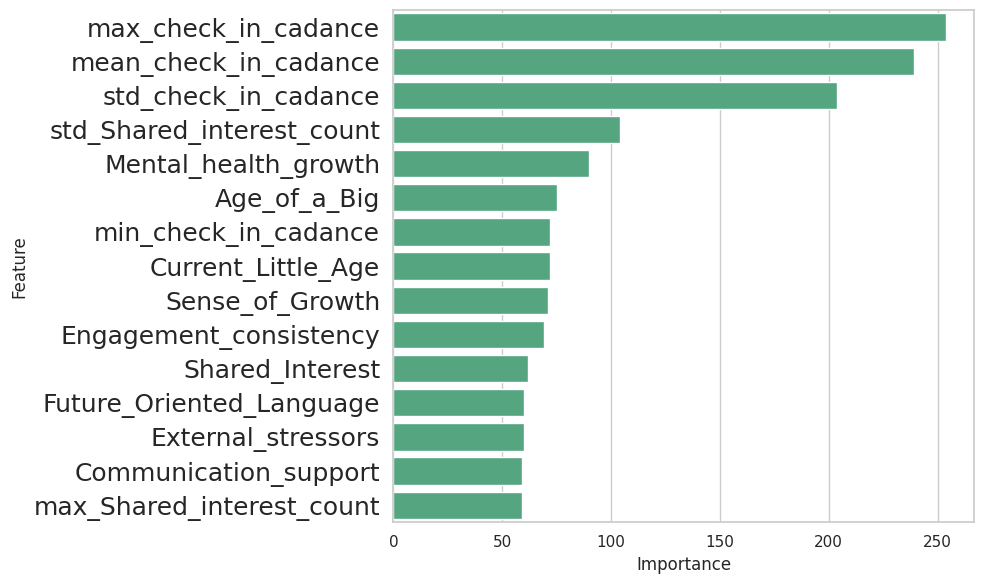

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot feature importance
def plot_feature_importance(importance_df, model_name):
    # Copy dataframe to avoid modifying the original data
    df = importance_df.copy()

    # Replace specific feature names for better readability
    df['Feature'] = df['Feature'].replace({
        'max_days': 'max_check_in_cadance',
        'mean_days': 'mean_check_in_cadance',
        'std_days': 'std_check_in_cadance',
        'min_days': 'min_check_in_cadance',
        'Big Age': 'Age_of_a_Big',
        'Engagement_consistency_positive': 'Engagement_consistency',
        'Mental_health_growth_positive': 'Mental_health_growth',
        'Communication_Support_Positive': 'Communication_support',
        'std_shared': 'std_Shared_interest_count',
        'max_shared': 'max_Shared_interest_count',
        'External_Stressors_Mentioned': 'External_stressors',
        'Little Closure Age': 'Current_Little_Age'

    })

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=df.head(15), color='#48B281')
    #plt.title(f'{model_name} - Top 15 Feature Importance')

    # Y-axis adjust the font size
    plt.yticks(fontsize=18)

    plt.tight_layout()
    plt.show()

plot_feature_importance(lgbm_importance_df, 'LightGBM')

## understand the performance at different levels of the ground-truth match lengths

In [ ]:
# Divide the data into 10 equal parts: use actual Match Length (i.e., y_test) to split the data into 10 quantiles
# Calculate quantiles
y_test_df_lgbm = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred_lgbm})
y_test_df_lgbm['Decile'] = pd.qcut(y_test_df_lgbm['y_true'], 10, labels=False)

# Check the distribution of deciles
y_test_df_lgbm.groupby('Decile')['y_true'].describe()

# Calculate RMSE for each decile using mean_squared_error
rmse_per_decile_lgbm = (
    y_test_df_lgbm.groupby('Decile')
    .apply(lambda x: np.sqrt(mean_squared_error(x['y_true'], x['y_pred'])))
)
print("LightGMB RMSE different deciles")
print(rmse_per_decile_lgbm)

LightGMB RMSE different deciles
Decile
0     2.333404
1     2.401143
2     3.028363
3     3.971553
4     5.310007
5     6.075056
6     6.825124
7     7.460106
8     9.704244
9    12.653031
dtype: float64


/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3473: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  if (await self.run_code(code, result,  async_=asy)):


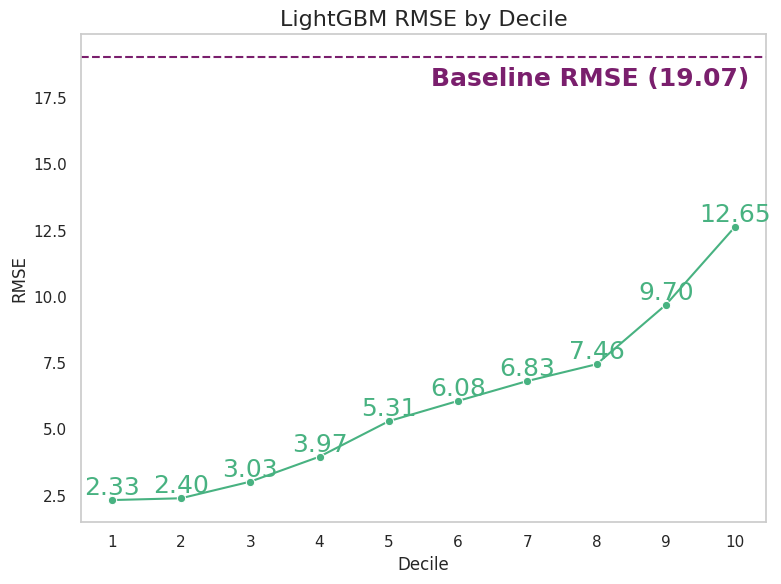

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

# Set baseline RMSE
baseline_rmse = 19.07


# Calculate RMSE for each decile
rmse_per_decile_lgbm = (
    y_test_df_lgbm.groupby('Decile')
    .apply(lambda x: np.sqrt(mean_squared_error(x['y_true'], x['y_pred'])))
)

# Set visualization style
sns.set(style="whitegrid")

# Create figure and axis
fig, ax2 = plt.subplots(figsize=(8, 6))

# Plot RMSE line chart
sns.lineplot(
    x=rmse_per_decile_lgbm.index,
    y=rmse_per_decile_lgbm.values,
    color='#48B281', marker='o', ax=ax2
)

# Add RMSE values at each point
for i, value in enumerate(rmse_per_decile_lgbm.values):
    ax2.text(i, value, f'{value:.2f}', color='#48B281', ha='center', va='bottom', fontsize=18)

# Add baseline RMSE horizontal line
ax2.axhline(y=baseline_rmse, color='#7A1F6D', linestyle='--', linewidth=1.5)

# Adjust baseline RMSE label position (offset downward by 1.0)
ax2.text(len(rmse_per_decile_lgbm)-0.8, baseline_rmse-0.4, 'Baseline RMSE (19.07)',
         color='#7A1F6D', fontsize=18, ha='right', va='top', fontweight='bold')

# Set Y-axis label (RMSE)
ax2.set_ylabel('RMSE', fontsize=12)
ax2.set_xlabel('Decile', fontsize=12)
ax2.set_title('LightGBM RMSE by Decile', fontsize=16)

# Turn off grid lines (horizontal lines)
ax2.grid(False)

# Hide legend
ax2.legend().remove()

ax2.set_xticks(rmse_per_decile_lgbm.index)
ax2.set_xticklabels(rmse_per_decile_lgbm.index + 1)

# Show plot
plt.tight_layout()
plt.show()

<ipython-input-18-e034929cc87c>:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.sqrt(mean_squared_error(x['y_true'], x['y_pred'])))
<ipython-input-18-e034929cc87c>:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  y_test_df_lgbm.groupby('Quartile')
<ipython-input-18-e034929cc87c>:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either p

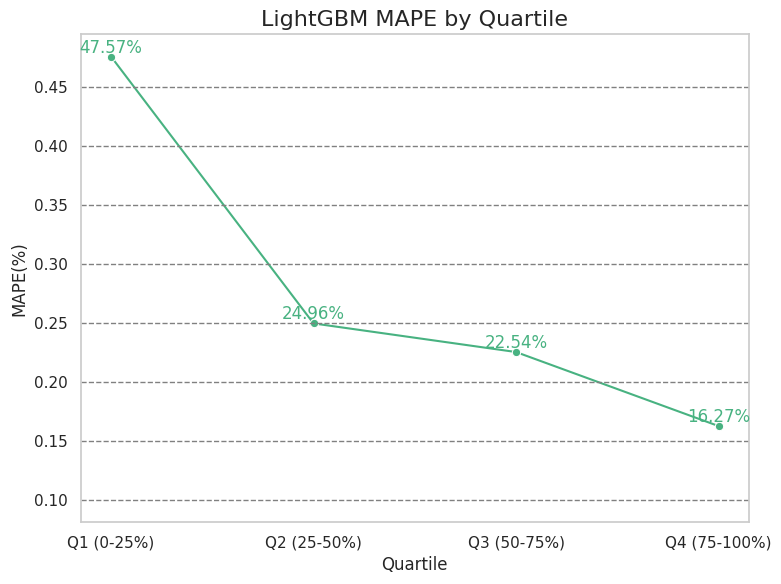

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error

# Divide the data into 10 equal parts: based on the actual Match Length (i.e., y_test), divide into 10 quantiles
# Compute quantiles
y_test_df_lgbm = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred_lgbm})
y_test_df_lgbm['Decile'] = pd.qcut(y_test_df_lgbm['y_true'], 10, labels=False)

# Check the distribution of each decile
y_test_df_lgbm.groupby('Decile')['y_true'].describe()

# Compute RMSE for each Decile using mean_squared_error
rmse_per_decile_lgbm = (
    y_test_df_lgbm.groupby('Decile')
    .apply(lambda x: np.sqrt(mean_squared_error(x['y_true'], x['y_pred'])))
)


# Set quartile group labels
quartile_labels = ['Q1 (0-25%)', 'Q2 (25-50%)', 'Q3 (50-75%)', 'Q4 (75-100%)']

# Divide the data into 4 quantiles based on y_true
y_test_df_lgbm['Quartile'] = pd.qcut(y_test_df_lgbm['y_true'], q=4, labels=quartile_labels)

# Calculate MAPE for each Quartile
mape_per_quartile_lgbm = (
    y_test_df_lgbm.groupby('Quartile')
    .apply(lambda x: mean_absolute_percentage_error(x['y_true'], x['y_pred']))
)

# Set visualization style
sns.set(style="whitegrid")

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot MAPE line chart
sns.lineplot(
    x=mape_per_quartile_lgbm.index,
    y=mape_per_quartile_lgbm.values,
    color='#48B281', marker='o', ax=ax
)

# Add numeric labels (MAPE values) above each point
for i, value in enumerate(mape_per_quartile_lgbm.values):
    ax.text(i, value, f'{value:.2%}', color='#48B281', ha='center', va='bottom', fontsize=12)

# Set axis labels
ax.set_ylabel('MAPE(%)', fontsize=12)
ax.set_xlabel('Quartile', fontsize=12)
ax.set_title('LightGBM MAPE by Quartile', fontsize=16)

# Add horizontal reference lines for specific Y-axis values (e.g., 10%, 20%, 30%)
y_ref_lines = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
for y_val in y_ref_lines:
    ax.axhline(y=y_val, color='gray', linestyle='--', linewidth=1)

# Turn off grid lines (horizontal)
ax.grid(False)

# Show plot
plt.tight_layout()
plt.show()